# Aim of this document is to create a model find a cruise condition for the simplifeied model at differnt AoA, linearise the EoM about this point and extrapolate across all V's

In [62]:
import sympy as sym
import sympy.physics.mechanics as me
import pandas as pd
import seaborn as sns

import numpy as np
from scipy.integrate import odeint,LSODA,BDF,solve_ivp
import matplotlib.pyplot as plt

import sys, os

sys.path.insert(1, os.path.join(sys.path[0], '..\..'))
import sympyTransforms as symt
import custom_plot_objects as cpo
import FwtModels.dof2 as dof2
import FwtModels.AeroModels as ams

me.mechanics_printing()

### Define the problem

In [63]:
# create instance of a simplified model parameters
p = dof2.Simplified2DofModel(inner_freq=2,inner_mass=4,mass_ratio=4)

# potential Energy
half = sym.Rational(1,2)
U = half*p.k*(p.q[1])**2 # + p.m*p.g*(-p.l*sym.sin(p.q[0]))

# Transforms for the mass
wing_frame = symt.HomogenousTransform().Translate(0,0,p.q[1])
fwt_frame = wing_frame.R_x(p.q[0])
fwt_com_frame = fwt_frame.Translate(0,p.l,0)
rot = sym.Matrix([p.q[0],0,0])

mw = dof2.RigidElement.PointMass(wing_frame,sym.Matrix([0,0,0]),p.m_w)
M_fwt = dof2.MassMatrix(p.m,I_xx = p.I_xx)
m = dof2.RigidElement(fwt_com_frame,rot,M_fwt)

# External Forces
AeroForces = ams.AeroModelv1(p,fwt_frame,at_mode=1)
GravityForces = ams.GravityModel(p,fwt_com_frame,sym.Matrix([0,0,p.g*p.m]))
CompositeForce = ams.CompositeForce([GravityForces,AeroForces])

# create instance of the model
sM = dof2.SymbolicModel(U,[mw,m],p,ExtForces = CompositeForce)

### Determine the fixed points of this system (about a fixed cruise condition)

In [94]:
## cruise angle to linearise about
c_angle = -5.5

#make alternative dataset
from scipy.optimize import minimize
vs = np.linspace(0,50,201)
aoa = [2.5,5,7.5,10]

df = pd.DataFrame(columns=['v','aoa','eta','q1'])

def ToMinimise(v):
    p.V.value = v[0]
    val = sM.deriv(0,[np.deg2rad(c_angle),0,v[1],0],p)
    return sum(np.array(val)**2)
    

for i in aoa:
    p.alpha_r.value = np.deg2rad(i)
    res = minimize(ToMinimise,[40,-0.006]).x
    df = df.append({'aoa' : i, 'v' : res[0],'eta':np.deg2rad(c_angle),'q1':res[1]} , ignore_index=True)
        
df

,v,aoa,eta,q1
0,43.541790,2.5,-0.095993,-0.006041
1,26.922191,5.0,-0.095993,-0.006041
2,21.197338,7.5,-0.095993,-0.006041
3,18.071458,10.0,-0.095993,-0.006041


### Linearise the system about these fixed points

In [95]:
# create complete EoM
func = dof2.LinearEoM_func(sM,p,ignore=[p.V,p.alpha_r])

In [96]:
flutdfv2 = pd.DataFrame()
vs = np.linspace(0,50,201)

for i in range(0,len(df)):
    # get the fixed point
    lp = [df['eta'].iloc[i],0,df['q1'].iloc[i],0]
    aoa_lp = np.deg2rad(df['aoa'].iloc[i])
    for v in vs:    
        # get the jacobian evaluated at this point
        j_lp = func(v,aoa_lp,lp)
        # get eigen value information
        jac_dat = dof2.ExtractEigenValueData(j_lp)
        # populate test specific data   
        jac_dat['V'] = v
        jac_dat['aoa'] = np.round(np.rad2deg(aoa_lp),1)
        jac_dat['lp'] = [lp for i in range(0,len(jac_dat))]
        flutdfv2 = flutdfv2.append(jac_dat,sort=False)
        
flutdfv2 = flutdfv2.reset_index(drop=True)
flutdfv2   

,Mode,cn,Real,Imag,Frequency,Damping,Stable,V,aoa,lp
0,0,-0.000000+13.604271j,-1.110223e-16,13.604271,2.165187,6.123234e-17,False,0.00,2.5,"[-0.09599310885968812, 0, -0.0060410668770586, 0]"
1,1,-1.080142+0.000000j,-1.080142e+00,0.000000,0.000000,NaN,False,0.00,2.5,"[-0.09599310885968812, 0, -0.0060410668770586, 0]"
2,2,1.080142+0.000000j,1.080142e+00,0.000000,0.000000,NaN,False,0.00,2.5,"[-0.09599310885968812, 0, -0.0060410668770586, 0]"
3,0,-0.003169+13.604249j,-3.168997e-03,13.604249,2.165184,-2.329417e-04,False,0.25,2.5,"[-0.09599310885968812, 0, -0.0060410668770586, 0]"
4,1,1.060797+0.000000j,1.060797e+00,0.000000,0.000000,NaN,False,0.25,2.5,"[-0.09599310885968812, 0, -0.0060410668770586, 0]"
...,...,...,...,...,...,...,...,...,...,...
1684,1,0.688480+12.406746j,6.884805e-01,12.406746,1.977633,5.540718e-02,False,49.50,10.0,"[-0.09599310885968812, 0, -0.00604106612860927..."
1685,0,-4.922257+11.570294j,-4.922257e+00,11.570294,2.001182,-3.914695e-01,False,49.75,10.0,"[-0.09599310885968812, 0, -0.00604106612860927..."
1686,1,0.705701+12.413092j,7.057008e-01,12.413092,1.978795,5.675968e-02,False,49.75,10.0,"[-0.09599310885968812, 0, -0.00604106612860927..."
1687,0,-4.960378+11.615007j,-4.960378e+00,11.615007,2.010107,-3.927496e-01,False,50.00,10.0,"[-0.09599310885968812, 0, -0.00604106612860927..."


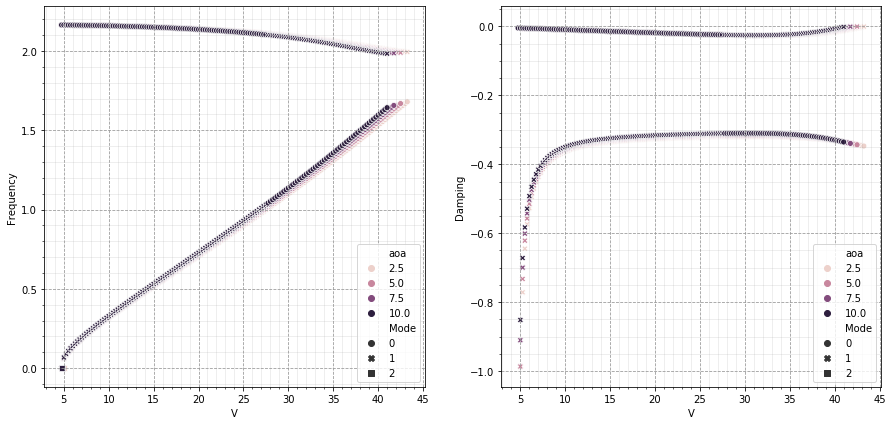

In [97]:
#data = flutdf[(flutdf['aoa']==5) & (flutdf['Damping']<0)]
data = flutdfv2[(flutdfv2['Stable'])]
#data = flutdfv2
fig, axes = plt.subplots(1,2,figsize=(15,7))


sns.scatterplot(data=data,x='V',y='Frequency',hue='aoa',style='Mode',ax=axes[0])
sns.scatterplot(data=data,x='V',y='Damping',hue='aoa',style='Mode',ax=axes[1])
for i in [0,1]:
    #axes[i].set(xlim=(0,80))
    axes[i].grid(b=True, which='major', color='#999999', linestyle='--')
    axes[i].minorticks_on()
    axes[i].grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

In [99]:
# get info for the first unstable point for each AoA

aoas = data['aoa'].unique()
idx = []

data = flutdfv2[flutdfv2['Stable']]
for i in data['aoa'].unique():
    idx.append(data[data['aoa']==i].sort_values(by=['V'],axis=0,ascending=False).head(1).index[0])
    
res = flutdfv2.iloc[idx].copy()
res['eta'] = res.apply(lambda row: np.rad2deg(row.lp[0]),axis=1)
res[['aoa','V','eta']]

,aoa,V,eta
368,2.5,43.25,-5.5
784,5.0,42.50,-5.5
1200,7.5,41.75,-5.5
1616,10.0,41.00,-5.5
